In [71]:
import pandas as pd
import numpy as np

In [72]:
df = pd.read_json('P2_player_state.json')

In [73]:
df = df.loc[((df['Season']== '21/22'))]
df = df.loc[(df.Competition =='Bundesliga')|(df.Competition =='Ligue 1')|(df.Competition =='Serie A')|(df.Competition =='Premier League')|(df.Competition =='LaLiga')]
cols_with_dash = df.columns[df.isin(['-']).any()]
df[cols_with_dash] = df[cols_with_dash].replace('-', 0, regex=True)

In [74]:
cols_to_convert = [ 'Apperance', 'Goals','Assists','Yellow_card','Red_card','Clean_sheets','Goals_conceded']
df[cols_to_convert] = df[cols_to_convert].fillna(0)
df[cols_to_convert] = df[cols_to_convert].astype(int)
cols_to_convert = ['PPG']
df[cols_to_convert] = df[cols_to_convert].replace(',', '.', regex=True)
df[cols_to_convert] = df[cols_to_convert].fillna(0)
df[cols_to_convert] = df[cols_to_convert].astype(float)

In [75]:

grouped_df = df.groupby('Player_id').agg({'Goals': 'sum', 'Assists': 'sum', 'Apperance': 'sum','Yellow_card':sum,'Red_card': 'sum','Clean_sheets':'sum','Goals_conceded':'sum','PPG':'mean'})
new_df = grouped_df.reset_index()[['Player_id', 'Goals', 'Assists', 'Apperance','Yellow_card','Red_card','Goals_conceded','Clean_sheets','PPG']]
new_df = new_df.rename(columns={'Player_id':'id', "Goals":"goals_20_21","Assists":"assists_20_21","Apperance":"apperance_20_21",'Yellow_card':'yellow_card_20_21','Red_card':'red_card_20_21','Clean_sheets':'clean_sheet_20_21','Goals_conceded':'goal_conceded_20_21','PPG':'PPG_20_21'})

In [76]:
df = pd.read_json('players_transfers.json')

In [77]:
df = df.loc[:, ['Player_id','Date','Fee']] 
df['year'] = df['Date'].str[-2:]
df.year = df.year.str.replace('-','01')
df = df.loc[~df['Fee'].str.contains('Loan')]
df = df.loc[df['Fee'].str.contains('[kmb]')]

def convert_value_to_euros(value):
    value = value.replace('€', '')
    factor = 1 
    if value.endswith('m'):
        factor = 1000000
        value = value.replace('m', '')
    elif value.endswith('k'):
        factor = 1000
        value = value.replace('k', '')
    elif value.endswith('b'):
        factor = 1000000000
        value = value.replace('b', '')
    else:
        factor = 0
    return float(value)*factor
df=df.drop(columns='Date')
df.year = df.year.astype(int)
idx = df.groupby('Player_id')['year'].idxmax()
# select only those rows using the 'loc[]' indexer
df =df.loc[idx]
df['Fee']=df['Fee'].apply(convert_value_to_euros)
df = df[df['year'] <= 30]
df = df.rename(columns={'Player_id':'id'})
df_merged = pd.merge(new_df, df, on='id', how='left')

In [78]:
df_merged.Fee.isnull().sum()
df_merged.fillna(11)

,id,goals_20_21,assists_20_21,apperance_20_21,yellow_card_20_21,red_card_20_21,goal_conceded_20_21,clean_sheet_20_21,PPG_20_21,Fee,year
0,2857,0,0,0,0,0,0,0,0.00,2300000.0,17.0
1,3333,0,1,24,2,0,0,0,2.63,22000000.0,10.0
2,3455,8,3,23,2,0,0,0,2.13,21000000.0,12.0
3,5578,0,0,0,0,0,0,0,0.00,1500000.0,6.0
4,6442,0,0,0,0,0,0,0,0.00,2900000.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...
3465,988862,1,0,3,0,0,0,0,2.00,11.0,11.0
3466,991487,0,0,0,0,0,0,0,0.00,11.0,11.0
3467,991649,0,0,2,0,0,0,0,1.50,11.0,11.0
3468,1011200,0,0,1,0,0,0,0,3.00,11.0,11.0


In [79]:
df_temp = pd.read_json('table_for_statistics.json')
df_total = pd.merge(df_merged, df_temp, on='id', how='left')

In [80]:
dfcolumns = (df_total.columns).to_list()
F= ['total_second_yellow_card','age','total_sub_on','citizenship','foot','nationality','total_sub_off','total_penalty','total_minutes_per_goal', 'total_minutes_played','birth_place','available_positions','current_market_value', 'highest_market_value','Team_ID','Team_ID','total_goal_conceded', 'total_clean_sheets','current_teanm_MV']
selected_cols = [x for x in dfcolumns if x not in F]

In [81]:
df_total = df_total[selected_cols]

In [82]:
import warnings
warnings.filterwarnings('ignore')
mid_pos = ['Central Midfield', 'Attacking Midfield', 'Defensive Midfield','Left Midfield', 'Right Midfield']
att_pos = ['Centre-Forward','Right Winger', 'Left Winger','Second Striker']
def_pos = ['Centre-Back','Left-Back','Right-Back']
df_total['pos'] = 'GK'
df_total.loc[df_total['main_position'].isin(mid_pos), 'pos'] = 'MID'
df_total.loc[df_total['main_position'].isin(att_pos), 'pos'] = 'ATT'
df_total.loc[df_total['main_position'].isin(def_pos), 'pos'] = 'DEF'
df_total = df_total.drop(columns='main_position')
df_total.fillna(0)

,id,goals_20_21,assists_20_21,apperance_20_21,yellow_card_20_21,red_card_20_21,goal_conceded_20_21,clean_sheet_20_21,PPG_20_21,Fee,...,height,caps,international_goals,total_fix,goal_con_per_fix,clean_per_fix,goals_UCL,assists_UCL,apperance_UCL,pos
0,2857,0,0,0,0,0,0,0,0.00,2300000.0,...,191.0,1.0,0.0,272.0,1.242647,0.349265,0.0,0.0,6.0,GK
1,3333,0,1,24,2,0,0,0,2.63,22000000.0,...,175.0,61.0,1.0,429.0,0.000000,0.000000,4.0,16.0,73.0,MID
2,3455,8,3,23,2,0,0,0,2.13,21000000.0,...,195.0,122.0,62.0,543.0,0.000000,0.000000,48.0,28.0,124.0,ATT
3,5578,0,0,0,0,0,0,0,0.00,1500000.0,...,185.0,5.0,0.0,714.0,1.210084,0.287115,0.0,0.0,0.0,GK
4,6442,0,0,0,0,0,0,0,0.00,2900000.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,GK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3465,988862,1,0,3,0,0,0,0,2.00,0.0,...,182.0,0.0,0.0,8.0,0.000000,0.000000,0.0,0.0,0.0,ATT
3466,991487,0,0,0,0,0,0,0,0.00,0.0,...,180.0,0.0,0.0,6.0,0.000000,0.000000,0.0,0.0,0.0,MID
3467,991649,0,0,2,0,0,0,0,1.50,0.0,...,187.0,0.0,0.0,16.0,0.000000,0.000000,0.0,0.0,0.0,DEF
3468,1011200,0,0,1,0,0,0,0,3.00,0.0,...,184.0,3.0,0.0,24.0,0.000000,0.000000,0.0,0.0,0.0,DEF


In [83]:
df_total.columns

Index(['id', 'goals_20_21', 'assists_20_21', 'apperance_20_21',
       'yellow_card_20_21', 'red_card_20_21', 'goal_conceded_20_21',
       'clean_sheet_20_21', 'PPG_20_21', 'Fee', 'year', 'total_squad',
       'total_apperance', 'total_ppg', 'total_goals_in_clubs', 'total_assists',
       'total_own_goal', 'total_yellow_card', 'total_red_card', 'full_name',
       'height', 'caps', 'international_goals', 'total_fix',
       'goal_con_per_fix', 'clean_per_fix', 'goals_UCL', 'assists_UCL',
       'apperance_UCL', 'pos'],
      dtype='object')

In [84]:
co_attack = [.9,.4,.075,-.5,-1,0,0,.5,1/1000000,0,0,0,.05,.01,.005,-.1,-.05,-.12,.01,.1,.5,0,0,0,.05,.03,.005] 
co_mid = [.65,.65,.075,-.4,-.9,0,0,.5,1/1000000,0,0,0,.05,.0075,.0075,-.1,-.04,-.1,.01,.1,.5,0,0,0,.04,.04,.005] 
co_deff = [.1,.1,.2,-.1,-.5,-.1,.1,.5,1/500000,0,0,0,.05,.005,.005,-.1,-.01,-.05,.01,.1,.05,0,-.5,1,.005,.005,.01]
co_gk = [0,0,.28,-.12,-.7,-.2,1,.5,1/300000,0,0,0.4,.05,0,0,-.07,-.012,-.07,.01,.2,0,0.3,-.3,1.2,0,0,.013]
len(co_attack)

27

In [85]:
input = df_total.drop(columns=['id','pos','full_name'])

In [86]:
output_att = pd.DataFrame(input.values * co_attack, columns=input.columns)
output_def = pd.DataFrame(input.values * co_deff, columns=input.columns)
output_mid = pd.DataFrame(input.values * co_mid, columns=input.columns)
output_gk = pd.DataFrame(input.values * co_gk, columns=input.columns)
output_att['row_sum'] = output_att.sum(axis=1)
output_def['row_sum'] = output_def.sum(axis=1)
output_mid['row_sum'] = output_att.sum(axis=1)
output_gk['row_sum'] = output_att.sum(axis=1)

In [87]:
df_total['Rating'] = 0
for i in range(len(df_total)):
    if df_total.loc[i, 'pos'] == 'ATT':
        df_total.loc[i,'Rating'] = max(0,min(output_att.loc[i, 'row_sum'],100))
    elif df_total.loc[i, 'pos'] == 'DEF':
        df_total.loc[i,'Rating'] = max(0,min(output_def.loc[i, 'row_sum']*1.1,100))
    elif df_total.loc[i, 'pos'] == 'GK':
        df_total.loc[i,'Rating'] = max(0,min(output_gk.loc[i, 'row_sum']*1.3 +2,100))
    elif df_total.loc[i, 'pos'] == 'MID':
        df_total.loc[i,'Rating'] = max(0,min(output_mid.loc[i, 'row_sum']*.9,100))
        

In [88]:
# df_total.loc[:,['full_name',"Rating"]].sample(n=15)

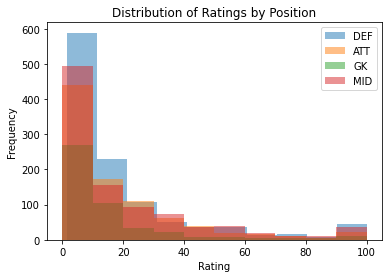

In [89]:
import matplotlib.pyplot as plt

# Group the DataFrame by 'pos' column and get the 'Rating' column
def_ratings = df_total[df_total['pos'] == 'DEF']['Rating']
att_ratings = df_total[df_total['pos'] == 'ATT']['Rating']
gk_ratings = df_total[df_total['pos'] == 'GK']['Rating']
mid_ratings = df_total[df_total['pos'] == 'MID']['Rating']
# Plot the histograms of the two distributions
plt.hist(def_ratings, alpha=0.5, label='DEF')
plt.hist(att_ratings, alpha=0.5, label='ATT')
plt.hist(gk_ratings, alpha=0.5, label='GK')
plt.hist(mid_ratings, alpha=0.5, label='MID')
plt.legend(loc='upper right')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings by Position')
plt.show()

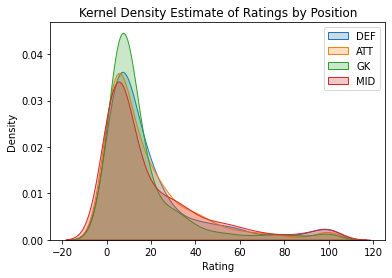

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group the DataFrame by 'pos' column and get the 'Rating' column
def_ratings = df_total[df_total['pos'] == 'DEF']
att_ratings = df_total[df_total['pos'] == 'ATT']
gk_ratings = df_total[df_total['pos'] == 'GK']
mid_ratings = df_total[df_total['pos'] == 'MID']
sns.kdeplot(data=def_ratings, x='Rating', label='DEF', fill=True)
sns.kdeplot(data=att_ratings, x='Rating', label='ATT', fill=True)
sns.kdeplot(data=gk_ratings, x='Rating', label='GK', fill=True)
sns.kdeplot(data=mid_ratings, x='Rating', label='MID', fill=True)
# Add a legend, axis labels, and title to the plot
plt.legend(loc='upper right')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of Ratings by Position')
plt.show()

In [91]:
mv = df_temp.loc[:,['current_market_value','id']]
df_coach = pd.merge(df_total, mv, on='id', how='left')
df_coach = df_coach.dropna(subset=['current_market_value'])

In [92]:
# calculate the cutoff values for rating and market value
df_coach = df_coach.loc[:,['id','pos','Rating','current_market_value','full_name']]
rating_cutoff = df_coach['Rating'].quantile(0.7)
mv_cutoff = df_coach['current_market_value'].quantile(0.4)

# filter the DataFrame using boolean indexing
filtered_df = df_coach[(df_coach['Rating'] >= rating_cutoff) & (df_coach['current_market_value'] <= mv_cutoff)]

In [93]:
filtered_df.sample(20)

,id,pos,Rating,current_market_value,full_name
134,40423,GK,90.10490,1000000.0,Claudio Bravo
475,90681,DEF,100.00000,700000.0,Eliaquim Mangala
56,25488,MID,35.42850,1500000.0,Antonio Candreva
434,84765,ATT,21.35300,1500000.0,Francesco Caputo
1414,264956,ATT,27.03450,1300000.0,Jean-Kvin Augustin
42,20506,MID,60.94620,1500000.0,Andrs Guardado
791,147485,MID,29.40930,1000000.0,Louis Schaub
409,80351,MID,52.83450,400000.0,Josip Ilicic
83,31514,DEF,21.28390,0.0,Markus Suttner
95,33706,ATT,32.66500,500000.0,Nani


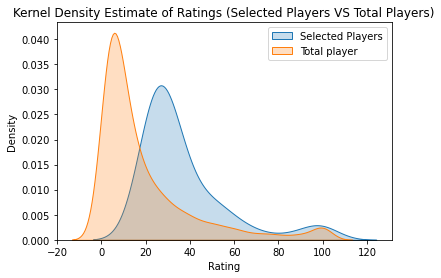

In [94]:
# Group the DataFrame by 'pos' column and get the 'Rating' column
selected_pl = filtered_df
total = df_coach
sns.kdeplot(data=selected_pl, x='Rating', label='Selected Players', fill=True)
sns.kdeplot(data=total, x='Rating', label='Total player ', fill=True)
# Add a legend, axis labels, and title to the plot
plt.legend(loc='upper right')
plt.xlabel('Rating')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of Ratings (Selected Players VS Total Players)')
plt.show()

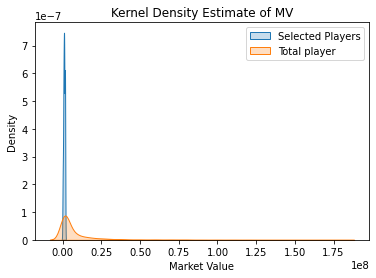

In [95]:
# Group the DataFrame by 'pos' column and get the 'Rating' column
selected_pl = filtered_df
total = df_coach
sns.kdeplot(data=selected_pl, x='current_market_value', label='Selected Players', fill=True)
sns.kdeplot(data=total, x='current_market_value', label='Total player ', fill=True)
# Add a legend, axis labels, and title to the plot
plt.legend(loc='upper right')
plt.xlabel('Market Value')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of MV')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


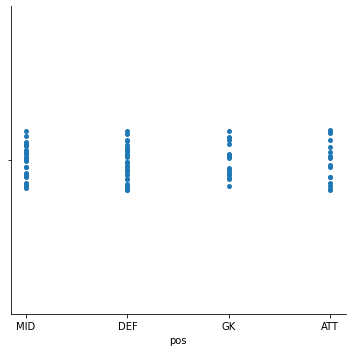

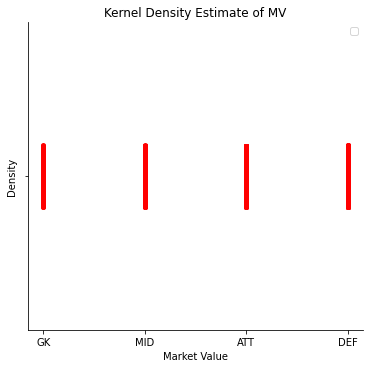

In [96]:
# Group the DataFrame by 'pos' column and get the 'Rating' column
selected_pl = filtered_df
total = df_coach
sns.catplot(data=selected_pl, x='pos')
sns.catplot(data=total, x='pos',color='r')
# Add a legend, axis labels, and title to the plot
plt.legend(loc='upper right')
plt.xlabel('Market Value')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of MV')
plt.show()

In [97]:
df_coach['selected'] = 'N'
df_coach.loc[df_coach['id'].isin(selected_pl['id']), 'selected'] = 'Y'
df_coach

,id,pos,Rating,current_market_value,full_name,selected
0,2857,GK,10.23550,200000.0,Eldin Jakupovic,N
1,3333,MID,54.01980,2000000.0,James Milner,N
2,3455,ATT,78.74000,2000000.0,Zlatan Ibrahimović,N
3,5578,GK,6.79570,150000.0,Nicolas Penneteau,N
6,7161,ATT,28.76950,13000000.0,Jonas Hofmann,N
...,...,...,...,...,...,...
3465,988862,ATT,4.09400,1000000.0,Moustapha Ciss,N
3466,991487,MID,3.39480,100000.0,Abdoul Ouattara,N
3467,991649,DEF,3.36710,300000.0,Eric N'Jo,N
3468,1011200,DEF,4.28285,2500000.0,Junior Mwanga,N


<AxesSubplot: xlabel='Position', ylabel='Percentage'>

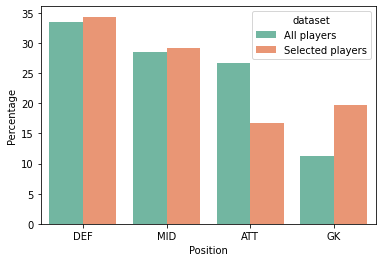

In [98]:
import pandas as pd
import seaborn as sns

# calculate the percent count of positions in each dataset
i = df_coach.pos.value_counts(normalize=True) * 100
j = selected_pl.pos.value_counts(normalize=True) * 100

# create a dataframe with the position counts for each dataset
df = pd.DataFrame({
    'Percentage': list(i.values) + list(j.values),
    'Position': list(i.index) + list(j.index),
    'dataset': ['All players'] * len(i) + ['Selected players'] * len(j)
})

# create the bar plot using Seaborn's barplot function
sns.barplot(data=df, x='Position', y='Percentage', hue='dataset', palette='Set2')

In [99]:
df = pd.read_json('teams.json')
df = df[['id', 'players_ids','year']]
df = df[df['year'] == '2021/2022']
df = df.rename(columns={'id': 'team_id'})
df = df.reset_index(drop=True)
result_df = df.explode('players_ids')
# duplicate_rows = result_df[result_df.duplicated(subset='players_ids')]
# result_df = result_df.drop_duplicates(subset='players_ids')
result_df = result_df.rename(columns={'players_ids': 'id'})
result_df = result_df[['id','team_id']].astype(int)
result_df

,id,team_id
0,315858,583
0,79422,583
0,207302,583
0,93730,583
0,460626,583
...,...,...
97,421780,380
97,267614,380
97,651206,380
97,542394,380


In [100]:
df_coach =pd.merge(df_coach, result_df, on='id', how='left')
# df_coach

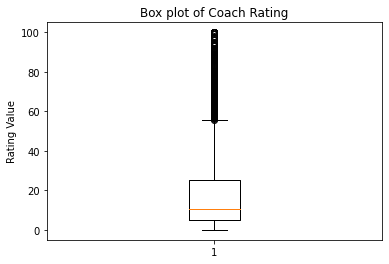

In [101]:
fig, ax = plt.subplots()
ax.boxplot(df_coach['Rating'])

# set the axis labels and title
ax.set_ylabel('Rating Value')
ax.set_title('Box plot of Coach Rating')

# show the plot
plt.show()

In [102]:
import pandas as pd

# define the IQR factor
iqr_factor = .1

# compute the IQR of the 'values' column
Q1 = df_coach['Rating'].quantile(0.25)
Q3 = df_coach['Rating'].quantile(0.75)
IQR = Q3 - Q1

# determine the upper and lower limits for outliers
lower_limit = Q1 - iqr_factor * IQR
upper_limit = Q3 + iqr_factor * IQR

# identify and remove any outliers
df_lower_outliers = df_coach.loc[(df_coach['Rating'] <= lower_limit)]

In [103]:
# len(df_lower_outliers)

In [104]:
# df_lower_outliers

In [105]:
df_outs = df_coach.sort_values(by='Rating').head(300)
# df_outs

In [106]:
#Players command
df = df_coach[~df_coach['pos'].str.contains('MID')]
df = df.replace('GK','DEF')

grouped = df.groupby(['team_id','pos'])[['Rating']].mean()

In [107]:
pivoted = pd.pivot_table(grouped, index="team_id", columns="pos", values="Rating")

# calculate the difference between ATT and DEF ratings
pivoted["diff"] = pivoted["ATT"] - pivoted["DEF"]

In [108]:
pivoted = pivoted.sort_values('diff')
pivoted

pos,ATT,DEF,diff
team_id,,,
985.0,43.707091,61.504882,-17.797791
29.0,27.362417,39.425573,-12.063157
621.0,7.229944,15.770230,-8.540286
3522.0,8.055750,16.195513,-8.139763
416.0,13.352364,21.414141,-8.061777
...,...,...,...
543.0,31.367125,18.726533,12.640592
13.0,36.029800,21.811228,14.218572
46.0,46.007429,29.598269,16.409159


In [109]:
teams = pd.read_json('teams.json')
teams = teams.rename(columns={'id':'team_id'})
teams = teams.loc[:,['team_name','team_id']]
Q2 = pd.merge(pivoted,teams,on='team_id',how='left')
Q2 = Q2.drop_duplicates()
Q2 = Q2.reset_index(drop=True)
Q2.head(20)

,team_id,ATT,DEF,diff,team_name
0,985.0,43.707091,61.504882,-17.797791,Manchester United
1,29.0,27.362417,39.425573,-12.063157,Everton FC
2,621.0,7.229944,15.770230,-8.540286,Athletic Bilbao
3,3522.0,8.055750,16.195513,-8.139763,Spezia Calcio
4,416.0,13.352364,21.414141,-8.061777,Torino FC
5,23826.0,21.212500,28.959718,-7.747218,RB Leipzig
6,252.0,10.699182,18.364908,-7.665726,Genoa CFC
7,1050.0,15.624708,22.955635,-7.330927,Villarreal CF
8,281.0,56.071389,63.219690,-7.148301,Manchester City
9,1038.0,13.188550,20.016989,-6.828439,UC Sampdoria
